## A much more structured and readable code for fitting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import plot 

In [2]:
class einstein_class():
    def __init__(self):
        self.avo=6.02214179e+23
        self.kb=1.3806505e-23
        self.apfu=1
        
    def set_apfu(self, apfu):
        self.apfu=apfu
        
    def einstein_fun(self, tt, eps):    
        return self.apfu*3*self.avo*self.kb*((eps/tt)**2)*np.exp(eps/tt)/((np.exp(eps/tt)-1)**2)
    
    def einstein_2_fun(self,tt,eps1,eps2):
        f1=self.apfu*3*self.avo*self.kb/2.
        f2=((eps1/tt)**2)*np.exp(eps1/tt)/((np.exp(eps1/tt)-1)**2)
        f3=((eps2/tt)**2)*np.exp(eps2/tt)/((np.exp(eps2/tt)-1)**2)
        return f1*(f2+f3)

In addition to the *einstein_class*, we define here an appropriate class for dealing with the data...

In [3]:
class data_class():
    def __init__(self, name, filename, apfu):
        self.name=name
        self.filename=filename
        self.path='.'
        self.apfu=apfu
        self.x_orig=np.array([])
        self.y_orig=np.array([])
        self.x=np.array([])
        self.y=np.array([])
        self.minx=0.
        self.maxx=0.
        self.num=0
        self.guess=50.
        self.bounds=(10., 2500.)
        self.model=1
        self.fit1=[]
        self.fit2=[]
        self.fit_flag=[False, False]
        self.n_plot=100
        self.selection_flag=False
        
    def read(self, path='default'):
        
        if path == 'default':
           path=self.path
        
        filename=path+'/'+self.filename
        data=np.loadtxt(filename)
        self.x_orig=data[:,0]
        self.y_orig=data[:,1]
        
        self.minx=np.min(self.x_orig)
        self.maxx=np.max(self.x_orig)
        
        self.num=self.x_orig.size
        
        self.x=np.copy(self.x_orig)
        self.y=np.copy(self.y_orig)
        self.selection_flag=False
        
    def get_apfu(self):
        return self.apfu
    
    def set_nplot(self,nplot):
        self.n_plot=nplot
        
    def select(self, tmin, tmax=0):
        
        if tmax == 0:
           tmax=self.maxx
        
        select=(self.x_orig >= tmin) & (self.x_orig <= tmax)
        self.x=self.x_orig[select]
        self.y=self.y_orig[select]
        self.fit_flag=[False, False]
        
        self.minx=np.min(self.x)
        self.maxx=np.max(self.x)
        self.selection_flag=True
        self.selection_min=tmin
        self.selection_max=tmax
        
    def info(self):
        print("Data set name %s" % self.name)
        print("Data set file %s" % self.filename)
        print("apfu: %4i" % self.apfu)
        print("Number of T points: %4i" % self.num)
        
        if self.selection_flag:
           print("Original temperature range restricted to the [%5.1f, %5.1f K] interval" \
                 % (self.selection_min, self.selection_max))
            
        print("Minimum and maximum temperatures: %5.1f, %5.1f" % (self.minx, self.maxx))
        if not (self.fit_flag[0] | self.fit_flag[1]):
           print("Fitting model:  None")
        else:
           if self.fit_flag[0]:
              print("one temperature model; Einstein temperature: %5.1f (K)" % self.fit1[0])
           if self.fit_flag[1]:
              print("two temperatures model; Einstein temperatures: %5.1f, %5.1f (K)" % (self.fit2[0], self.fit2[1]))

    def __repr__(self):
        print("Data set name %s" % self.name)
        print("Data set file %s" % self.filename)
        print("apfu: %4i" % self.apfu)
        print("Number of T points: %4i" % self.num)
        
        if self.selection_flag:
           print("Original temperature range restricted to the [%5.1f, %5.1f K] interval" \
                 % (self.selection_min, self.selection_max))
            
        print("Minimum and maximum temperatures: %5.1f, %5.1f" % (self.minx, self.maxx))
        if not (self.fit_flag[0] | self.fit_flag[1]):
           print("Fitting model:  None")
        else:
           if self.fit_flag[0]:
              print("one temperature model; Einstein temperature: %5.1f (K)" % self.fit1[0])
           if self.fit_flag[1]:
              print("two temperatures model; Einstein temperatures: %5.1f, %5.1f (K)" % (self.fit2[0], self.fit2[1]))
                
        return 'END'
                

In [4]:
ein=einstein_class()
my_plot=plot.plot_class('data_files')

Then we heavily modify the *einstein_fit* function so that it *exclusively* does the fit...

In [5]:
def einstein_fit(name, model=1):

    ein.set_apfu(name.get_apfu())
    guess=name.guess
    bounds=name.bounds
    
    if model==1:    
       guess=[guess]
       ein_fit, ein_cov=curve_fit(ein.einstein_fun, name.x, name.y, bounds=bounds,\
                      p0=guess, xtol=1e-15, ftol=1e-15)
    else:
       guess=[guess, guess]
       ein_fit, ein_cov=curve_fit(ein.einstein_2_fun, name.x, name.y, bounds=bounds,\
                      p0=guess, xtol=1e-15, ftol=1e-15)
        
    if model == 1:
       print("Einstein temperature:   %5.1f (K)" % ein_fit)
    else:        
       print("Einstein temperatures:  %5.1f, %5.1f (K)" % (ein_fit[0], ein_fit[1]))
    
    if model == 1: 
       name.model=1
       name.fit1=[ein_fit[0]]
       name.fit_flag[0]=True
    else:
       name.model=2
       name.fit2=[ein_fit[0], ein_fit[1]]
       name.fit_flag[1]=True

The plot of the fit(s) is the work of an appropriate function here defined:

In [6]:
def plot_fit(name):
    
    t_plot=np.linspace(name.minx, name.maxx, name.n_plot)
    
    cv1_plot=np.array([ein.einstein_fun(it, name.fit1[0]) for it in t_plot])
    cv2_plot=np.array([ein.einstein_2_fun(it, name.fit2[0], name.fit2[1]) for it in t_plot])
    
    x=[name.x, t_plot, t_plot]
    y=[name.y, cv1_plot, cv2_plot]
    style=['k*', 'k--', 'k-']
    label=['Actual values', '1p fit', '2p fit']
    
    my_plot.multi(x,y,style, label, xlab=r'$T (K)$', ylab=r'$C_v (J/mol\ J)$')

Comparison of fits is made by the *compare_fit* function that relies on the previously defined function:

In [7]:
def compare_fit(name, plot=True):
    
    if not name.fit_flag[0]:
       einstein_fit(name, model=1)
    if not name.fit_flag[1]:
       einstein_fit(name, model=2)
    
    print("")
    model1=np.array([ein.einstein_fun(it, name.fit1[0]) for it in name.x])
    model2=np.array([ein.einstein_2_fun(it, name.fit2[0], name.fit2[1]) for it in name.x])
    
    serie=[name.x, name.y, model1.round(2), model2.round(2)]
    df=pd.DataFrame(serie, index=['T  ', '   Cv Exp', ' model 1', ' model 2'])
    df=df.T
    print(df.to_string(index=False), '\n')  
    
    if plot:
       plot_fit(name)

Then, everything is now defined, and we can start working with our data. 

As a preliminary step, by using the method *set_param* of the *plot class*, we set some parameters for plotting.
Then we read the Cv data for pyrope, by creating an instance of the class *data_class*, reading the data from the appropriate file, and having a look at what we loaded

In [8]:
my_plot.set_param(tex=False, fsize=16, tsize=14, dpi=200, figsize=(8,6), save=True)
py=data_class('pyrope', 'cv_data.dat', 20)
py.read('data_files')
py.info()

Data set name pyrope
Data set file cv_data.dat
apfu:   20
Number of T points:   20
Minimum and maximum temperatures:  20.0, 700.0
Fitting model:  None


Then we do the fits...

Einstein temperature:   633.4 (K)
Einstein temperatures:  1017.9, 341.5 (K)

  T       Cv Exp   model 1   model 2
 20.0       4.37      0.00      0.00
 56.0      31.53      0.78     20.95
 92.0      85.15     24.25     88.72
127.0     141.41     85.85    146.39
163.0     193.78    161.22    194.16
199.0     238.55    228.10    235.96
235.0     276.19    281.44    273.00
271.0     307.68    322.55    305.14
306.0     333.31    353.28    331.75
342.0     355.39    377.77    354.78
378.0     373.85    396.88    374.00
414.0     389.33    411.98    390.02
449.0     402.00    423.77    403.07
485.0     413.02    433.63    414.37
521.0     422.34    441.72    423.91
557.0     430.27    448.42    432.00
593.0     437.06    454.03    438.91
628.0     442.75    458.65    444.69
664.0     447.85    462.70    449.84
700.0     452.32    466.18    454.31 



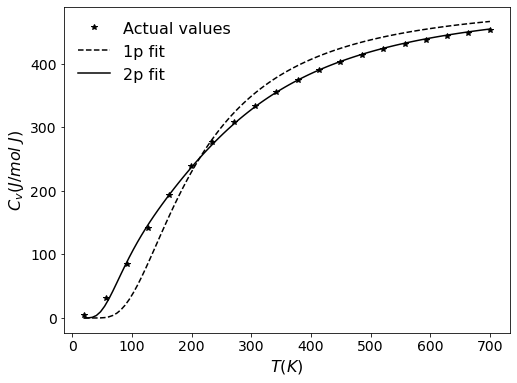

In [9]:
compare_fit(py)

In [10]:
print(py)

Data set name pyrope
Data set file cv_data.dat
apfu:   20
Number of T points:   20
Minimum and maximum temperatures:  20.0, 700.0
one temperature model; Einstein temperature: 633.4 (K)
two temperatures model; Einstein temperatures: 1017.9, 341.5 (K)
END


Now, select data for temperature higher then 300K... and redo the fits:

Einstein temperature:   716.9 (K)
Einstein temperatures:  258.9, 1066.9 (K)

  T       Cv Exp   model 1   model 2
306.0     333.31    321.88    333.82
342.0     355.39    350.26    355.23
378.0     373.85    372.81    373.46
414.0     389.33    390.88    388.91
449.0     402.00    405.14    401.65
485.0     413.02    417.15    412.79
521.0     422.34    427.08    422.26
557.0     430.27    435.35    430.35
593.0     437.06    442.30    437.29
628.0     442.75    448.04    443.13
664.0     447.85    453.10    448.34
700.0     452.32    457.46    452.89 



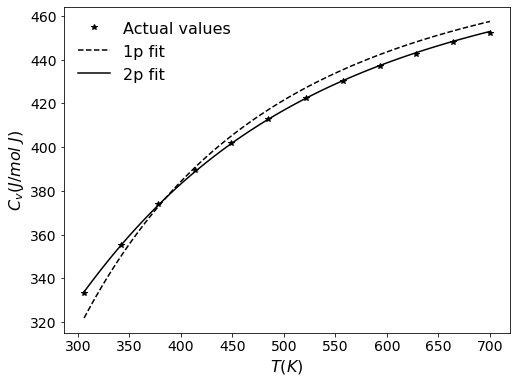

In [11]:
py.select(300)
compare_fit(py)

In [12]:
py.info()

Data set name pyrope
Data set file cv_data.dat
apfu:   20
Number of T points:   20
Original temperature range restricted to the [300.0, 700.0 K] interval
Minimum and maximum temperatures: 306.0, 700.0
one temperature model; Einstein temperature: 716.9 (K)
two temperatures model; Einstein temperatures: 258.9, 1066.9 (K)
